In [149]:
import pandas as pd
import spacy
import nltk
import re
import numpy as np

In [46]:
# load the dataset
dataset = pd.read_csv('nips-papers/papers.csv')
dataset.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [15]:
papers = dataset[dataset.abstract != 'Abstract Missing'][['id','year','abstract']]

In [18]:
papers['wordcount'] = papers.abstract.apply(lambda x: len(str(x).split(" ")))

In [56]:
papers = papers.reset_index(drop=True)

In [57]:
wordcount = pd.Series(''.join(papers['abstract']).split(' ')).str.lower().value_counts()

In [58]:
wordcount[:20]

the     31897
of      20921
a       16662
and     13636
to      13282
in      11181
we      10162
that     7850
is       7670
for      7527
on       5699
         5693
this     4763
with     4579
as       3853
our      3774
are      3532
an       3468
by       3366
can      2957
dtype: int64

In [59]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

lem = WordNetLemmatizer()
stem = PorterStemmer()
word = "inversely"
print("stemming:",stem.stem(word))
print("lemmatization:", lem.lemmatize(word, "v"))

stemming: invers
lemmatization: inversely


In [60]:
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
new_words = ["using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown"]
stop_words = stop_words.union(new_words)

In [63]:
corpus = []
for i in range(0, len(papers)):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', papers['abstract'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [64]:
text

'consider maximum likelihood estimation linear dynamical system generalized linear observation model maximum likelihood typically considered hard setting since latent state transition parameter must inferred jointly given expectation maximization scale prone local minimum moment matching approach subspace identification literature become standard despite known statistical efficiency issue paper instead reconsider likelihood maximization develop optimization based strategy recovering latent state transition parameter key approach view reformulation maximum likelihood estimation linear dynamical system enables use global optimization algorithm matrix factorization proposed estimation strategy outperforms widely used identification algorithm subspace identification method term accuracy runtime'

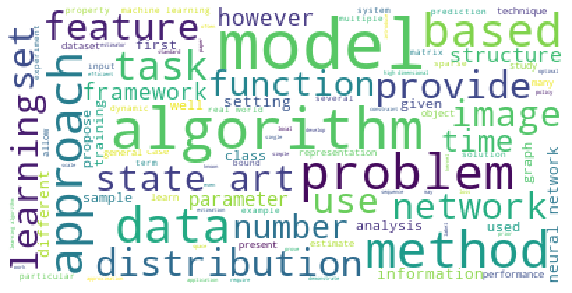

In [77]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1,figsize=(10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

In [114]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [116]:
X

<3924x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 323047 stored elements in Compressed Sparse Row format>

In [162]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)# get feature names
feature_names=cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted
doc=corpus[0]
 
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

In [163]:
#d = cv.transform([doc])
#d.toarray()

In [164]:
tf_idf_vector.tocoo()

<1x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 64 stored elements in COOrdinate format>

In [165]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())#extract only the top n; n here is 10

keywords=extract_topn_from_vector(feature_names,sorted_items,10)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
non negative matrix factorization nmf useful decomposition multivariate data different multi plicative algorithm nmf analyzed differ slightly multiplicative factor used update rule algorithm minimize conventional least square error minimizes generalized kullback leibler divergence monotonic convergence algorithm proven auxiliary func tion analogous used proving convergence expectation maximization algorithm algorithm interpreted diag onally rescaled gradient descent rescaling factor optimally chosen ensure convergence

Keywords:
nmf 0.288
convergence 0.208
algorithm 0.18
factor 0.162
algorithm minimize 0.156
rescaling 0.153
negative matrix factorization 0.153
non negative matrix 0.15
negative matrix 0.15
convergence algorithm 0.148


In [166]:
sorted_items

[(6051, 0.28825074275157225),
 (1831, 0.20814324927562952),
 (226, 0.1799869018835501),
 (3174, 0.1623357756993763),
 (315, 0.1555658148760662),
 (7883, 0.15273155092303878),
 (5957, 0.15273155092303878),
 (6092, 0.15023155293995982),
 (5956, 0.15023155293995982),
 (1832, 0.14799522853914235),
 (2039, 0.14412537137578613),
 (9618, 0.14242642885296133),
 (4795, 0.14242642885296133),
 (4559, 0.14242642885296133),
 (8735, 0.14085345376463979),
 (3030, 0.14085345376463979),
 (232, 0.14085345376463979),
 (8499, 0.13673240490730604),
 (5767, 0.13673240490730604),
 (5248, 0.13551919182853345),
 (4558, 0.13224727421738716),
 (4557, 0.13224727421738716),
 (4794, 0.13125986593221334),
 (2391, 0.13031635724989687),
 (6091, 0.12854654504381957),
 (494, 0.12771406774153496),
 (468, 0.1261410926532134),
 (776, 0.12467668788046334),
 (4407, 0.12330682870018603),
 (7432, 0.12202004379587966),
 (5888, 0.12080683071710707),
 (6364, 0.11857050631628963),
 (2851, 0.11753491310596077),
 (9641, 0.1142656164

In [167]:
from scipy import linalg

In [168]:
U, s, Vh = linalg.svd(X.todense(), full_matrices=False)

In [169]:
vocab = np.array(cv.get_feature_names())

In [173]:
vocab

array(['ability', 'ability model', 'able', ..., 'zero sum',
       'zero sum game', 'zeta'], dtype='<U35')

In [174]:
num_top_words = 15
def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [175]:
show_topics(Vh[:3])

['approval hearer scattering lsa conditional swap regret vlsi multiclass loss reproduction conditional swap ant revenue sharing scheme stochastic game solid border ownership ownership',
 'algorithm problem function learning bound optimization method convex matrix gradient optimal convergence regret loss setting',
 'learning network method task image feature neural deep neural network training approach object kernel representation layer']

In [183]:
Vh[:3]

(3, 10000)

In [177]:
U.shape

(3924, 3924)